<a href="https://colab.research.google.com/github/RamazanGeris/ReGe/blob/master/Text_classification_RG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
from google_play_scraper import reviews, Sort

result, continuation_token = reviews(
    'com.inomera.sm',  # Buraya analiz etmek istediğiniz uygulamanın paket adını yazın
    lang='tr',  # Dil seçeneği
    country='tr',  # Ülke seçeneği
    sort=Sort.NEWEST,  # Yorumları sıralama şekli
    count=20000  # Toplanacak yorum sayısı
)

import pandas as pd

# Yorumları ve puanları bir DataFrame'e aktarın
df = pd.DataFrame(result)
df = df[['content', 'score']]
df['sentiment'] = df['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

# Veri setini kaydedin
df.to_csv('google_play_reviews.csv', index=False)


In [ ]:
# CSV dosyasını okuyun
df = pd.read_csv('google_play_reviews.csv')

# İlk birkaç satırı görüntüleyin
print(df.head())


                                             content  score sentiment
0                                              Super      5  positive
1  2 senedir kullandığım mükemmel bi uygulama tüm...      5  positive
2  Uzun süredir kullandığım bi uygulama fakat az ...      4  positive
3                                Mükemmel bir hizmet      5  positive
4  Diğer zincir marketlere nazaran biraz pahalı g...      5  positive


In [ ]:
import pandas as pd

# CSV dosyasını okuyun
df = pd.read_csv('google_play_reviews.csv')

# Yorumların boş olmadığı satırları filtreleyin
df = df[df['content'].notna()]

# Yorumları ve etiketleri bir DataFrame'de saklayın
df = df[['content', 'score']]
df['sentiment'] = df['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

# Veri setini inceleyin
print(df.head())

# Veri setindeki duygu dağılımını kontrol edin
print(df['sentiment'].value_counts())


                                             content  score sentiment
0  Bir sipariş söyledim yarısını gönderdiler yarı...      1  negative
1                                            Süperrr      5  positive
2         Çok faydalanıyoruz acayip indirimler aldık      5  positive
3                                       Çok memnunum      5  positive
4                                              Super      5  positive
sentiment
positive    14152
negative     5334
neutral       514
Name: count, dtype: int64


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch

# BERT tokenizer ve modelini yükleyin
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Yorumları tokenize etme fonksiyonu
def tokenize_function(examples):
    return tokenizer(examples['content'], padding="max_length", truncation=True, max_length=128)

# Veri setini eğitim ve test olarak bölme
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'])

# DataFrame'i Dataset sınıfına çevirme
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['content']
        label = self.df.iloc[idx]['sentiment']
        encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encodings = {key: tensor.squeeze(0) for key, tensor in encodings.items()}
        encodings['labels'] = torch.tensor(self.labels[label])
        return encodings

train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)

# DataLoader oluşturma
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

# WandB ile oturum açma
import wandb
wandb.login()

# Eğitim argümanlarını ayarlayın
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=500,  # Her 500 adımdan sonra modeli kaydetmek için
    save_total_limit=3,  # Maksimum 3 kontrol noktası sakla
    load_best_model_at_end=True,  # Eğitim sonunda en iyi modeli yükle
    eval_strategy="steps",  # Güncellenmiş parametre
    eval_steps=500,  # Her 500 adımdan sonra değerlendirme yapmak için
    run_name="sentiment_analysis_run"  # Farklı bir run name
)

# Trainer nesnesini oluşturun
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Modeli eğitin
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ramazangeris (ramazangeris-kocaeli-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss
500,0.549400,0.536637
1000,0.402000,0.392063
1500,0.388700,0.340925
2000,0.397400,0.445764
2500,0.367700,0.383877
3000,0.353500,0.408340
3500,0.335600,0.346446
4000,0.344300,0.360636
4500,0.305300,0.406564
5000,0.301300,0.390513


TrainOutput(global_step=6000, training_loss=0.35812041982014975, metrics={'train_runtime': 1645.7735, 'train_samples_per_second': 29.166, 'train_steps_per_second': 3.646, 'total_flos': 3157361012736000.0, 'train_loss': 0.35812041982014975, 'epoch': 3.0})

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Test verisetinde tahmin yapma
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Gerçek etiketleri ve tahmin edilen etiketleri alın
true_labels = test_df['sentiment'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x]).values
pred_labels = preds

# Doğruluk oranını hesaplayın
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

# Ayrıntılı sınıflandırma raporu alın
report = classification_report(true_labels, pred_labels, target_names=['negative', 'neutral', 'positive'])
print(report)


Accuracy: 0.89175
              precision    recall  f1-score   support

    negative       0.80      0.85      0.82      1067
     neutral       0.00      0.00      0.00       103
    positive       0.93      0.94      0.93      2830

    accuracy                           0.89      4000
   macro avg       0.58      0.60      0.59      4000
weighted avg       0.87      0.89      0.88      4000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Yeni yorumları içeren bir liste oluşturun
new_reviews = ["Bu uygulama çok güzel olmuş", "tamamiyle çok kötü, arayüzü hiç beğenmedim", "uygulama ortalama ama geliştirilmeli"]

# Yeni yorumları tokenize edin
encodings = tokenizer(new_reviews, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Modeli CPU'ya taşı
model.to('cpu')

# Model ile tahmin yapın
with torch.no_grad():
    outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Tahmin edilen etiketleri insan-readable formata çevirin
labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [labels[pred.item()] for pred in predictions]

# Sonuçları gösterin
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}\nSentiment: {label}\n")


Review: Bu uygulama çok güzel olmuş
Sentiment: positive

Review: tamamiyle çok kötü, arayüzü hiç beğenmedim
Sentiment: negative

Review: uygulama ortalama ama geliştirilmeli
Sentiment: positive



In [ ]:
# Modeli kaydetme
model.save_pretrained('sentiment_analysis_model')
tokenizer.save_pretrained('sentiment_analysis_model')

print("Model ve tokenizer başarıyla kaydedildi.")


Model ve tokenizer başarıyla kaydedildi.


Confusion Matrix:
[[ 905    0  162]
 [  58    0   45]
 [ 168    0 2662]]


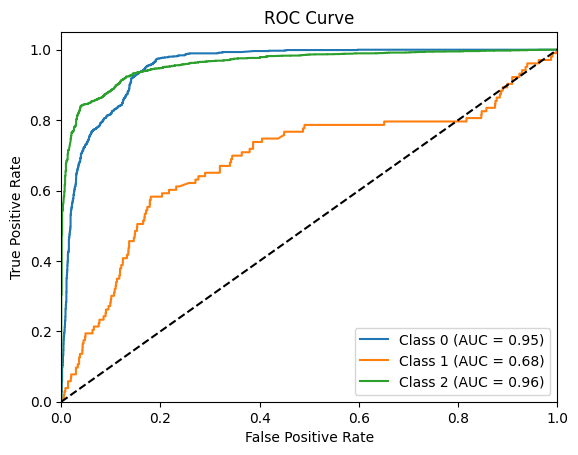

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Test setinde tahminler yaparak karmaşıklık matrisini hesapla
true_labels = test_df['sentiment'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x]).values

# Modeli GPU'ya taşı (eğer varsa)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    model.to(device) # Move the model to the GPU

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Karmaşıklık matrisi
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)

# ROC Eğrisi ve AUC Değeri
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisi çizme
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Buraya Kadar Bert Modelini Eğittik

ŞİMDİ sıra roberta modelini eğitmede


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time


In [ ]:
# Veriyi yükleme ve hazırlama
df = pd.read_csv('google_play_reviews.csv')  # Veri dosyanızın yolu

# İstenen dengeyi sağlamak için pozitif, negatif ve nötr yorumları filtreleme
positive_df = df[df['sentiment'] == 'positive'].sample(7000, random_state=42, replace=True)
negative_df = df[df['sentiment'] == 'negative'].sample(7000, random_state=42, replace=True)
neutral_df = df[df['sentiment'] == 'neutral'].sample(6000, random_state=42, replace=True)

# Verileri birleştirerek dengeli bir veri seti oluşturma
balanced_df = pd.concat([positive_df, negative_df, neutral_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Eğitim ve test setlerine bölme
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['sentiment'])

class SentimentDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['content']
        label = self.df.iloc[idx]['sentiment']
        encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encodings = {key: tensor.squeeze(0) for key, tensor in encodings.items()}
        encodings['labels'] = torch.tensor(self.labels[label])
        return encodings

# DataLoader oluşturma
train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
# RoBERTa tokenizer ve modeli yükeleme aşaması
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Eğitim argümanları
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True,
    eval_strategy="steps",
    eval_steps=500,
    run_name="roberta_sentiment_analysis"
)

# Trainer nesnesini oluşturma
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Model eğitimi
trainer.train()


Step,Training Loss,Validation Loss
500,0.718300,0.670948
1000,0.615300,0.451884
1500,0.409000,0.307181
2000,0.324100,0.286282
2500,0.235400,0.301256
3000,0.219900,0.255052
3500,0.154700,0.236343
4000,0.130000,0.249425
4500,0.089800,0.218452
5000,0.088000,0.209114


TrainOutput(global_step=5000, training_loss=0.29844047241210936, metrics={'train_runtime': 2206.6482, 'train_samples_per_second': 36.254, 'train_steps_per_second': 2.266, 'total_flos': 5262268354560000.0, 'train_loss': 0.29844047241210936, 'epoch': 5.0})

In [ ]:
# Test verisetinde tahmin yapma
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Gerçek etiketleri ve tahmin edilen etiketleri alın
true_labels = test_df['sentiment'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x]).values
pred_labels = preds

# Doğruluk oranını hesaplayın
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

# Ayrıntılı sınıflandırma raporu alın
report = classification_report(true_labels, pred_labels, target_names=['negative', 'neutral', 'positive'])
print(report)


Accuracy: 0.95775
              precision    recall  f1-score   support

    negative       0.95      0.95      0.95      1400
     neutral       0.96      1.00      0.98      1200
    positive       0.96      0.93      0.95      1400

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



Confusion Matrix:
[[1327   26   47]
 [   0 1198    2]
 [  69   25 1306]]


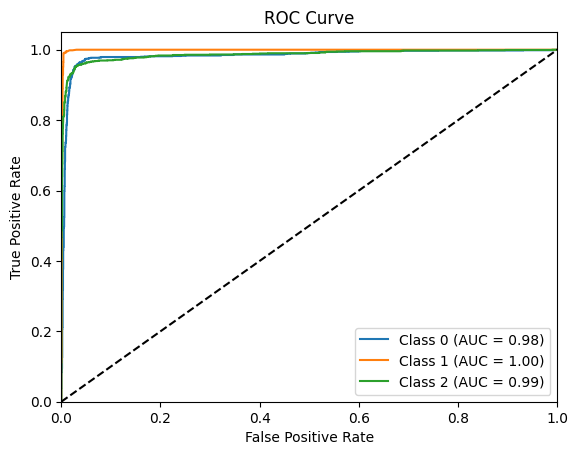

In [ ]:
# Karmaşıklık matrisi
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)

# ROC Eğrisi ve AUC Değeri
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisi çizme
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Roberta Modelini eğittik ve Test Ettik
Şimdi DeBERTa Modelini Eğitip Test Edeceğiz

In [ ]:
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time


In [ ]:
# Veriyi yükleme ve hazırlama
df = pd.read_csv('google_play_reviews.csv')  # Veri dosyasının yolu

# İstenen dengeyi sağlamak için pozitif, negatif ve nötr yorumları filtreleme
positive_df = df[df['sentiment'] == 'positive'].sample(7000, random_state=42)
negative_df = df[df['sentiment'] == 'negative'].sample(7000, random_state=42, replace=True)
neutral_df = df[df['sentiment'] == 'neutral'].sample(6000, random_state=42, replace=True)

# Verileri birleştirerek dengeli bir veri seti oluşturma
balanced_df = pd.concat([positive_df, negative_df, neutral_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Eğitim ve test setlerine bölme
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['sentiment'])

class SentimentDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['content']
        label = self.df.iloc[idx]['sentiment']
        encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encodings = {key: tensor.squeeze(0) for key, tensor in encodings.items()}
        encodings['labels'] = torch.tensor(self.labels[label])
        return encodings

# DataLoader oluşturma
train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
# DeBERTa tokenizer ve modelini yükleme
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Eğitim argümanlarını ayarlayın
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True,
    eval_strategy="steps",
    eval_steps=500,
    run_name="deberta_sentiment_analysis"
)

# Trainer nesnesini oluşturun
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Modeli eğitin
trainer.train()


Step,Training Loss,Validation Loss
500,0.929900,0.868841
1000,1.020700,1.040361
1500,0.977100,0.937133
2000,0.876300,0.978124
2500,0.831000,0.904568
3000,0.828000,0.815085
3500,0.923300,1.008114
4000,0.798300,0.806971
4500,0.766600,0.754362
5000,0.723300,0.755553


TrainOutput(global_step=10000, training_loss=0.7685514495849609, metrics={'train_runtime': 4234.5462, 'train_samples_per_second': 18.892, 'train_steps_per_second': 2.362, 'total_flos': 6131999232000000.0, 'train_loss': 0.7685514495849609, 'epoch': 5.0})

In [ ]:
# Test verisetinde tahmin yapma
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Gerçek etiketleri ve tahmin edilen etiketleri alın
true_labels = test_df['sentiment'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x]).values
pred_labels = preds

# Doğruluk oranını hesaplayın
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

# Ayrıntılı sınıflandırma raporu alın
report = classification_report(true_labels, pred_labels, target_names=['negative', 'neutral', 'positive'])
print(report)


Accuracy: 0.7495
              precision    recall  f1-score   support

    negative       0.70      0.79      0.74      1400
     neutral       0.63      0.60      0.62      1200
    positive       0.92      0.83      0.88      1400

    accuracy                           0.75      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.76      0.75      0.75      4000



Confusion Matrix:
[[1106  256   38]
 [ 417  724   59]
 [  59  173 1168]]


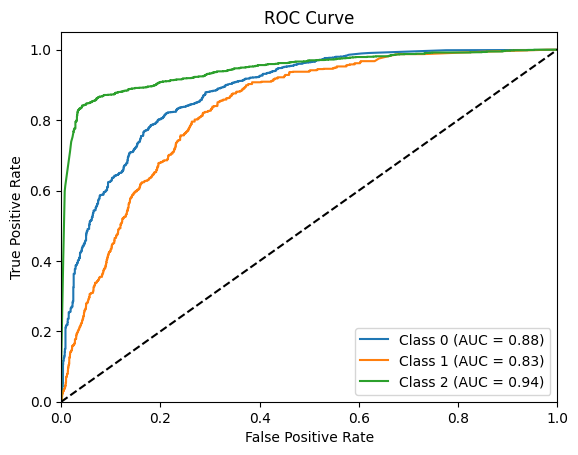

In [ ]:
# Karmaşıklık matrisi
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)

# ROC Eğrisi ve AUC Değeri
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisi çizme
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time


In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time

# Dengeli veri çekme hedefleri
TARGET_POSITIVE = 7000
TARGET_NEGATIVE = 7000
TARGET_NEUTRAL = 6000

pos_reviews, neg_reviews, neu_reviews = [], [], []

while len(pos_reviews) < TARGET_POSITIVE or len(neg_reviews) < TARGET_NEGATIVE or len(neu_reviews) < TARGET_NEUTRAL:
    result, _ = reviews(
        'com.inomera.sm',  # Buraya analiz etmek istediğiniz uygulamanın paket adını yazın
        lang='tr',  # Dil seçeneği
        country='tr',  # Ülke seçeneği
        sort=Sort.NEWEST,  # Yorumları sıralama şekli
        count=10000  # Her istekte 10000 yorum çek
    )

    df = pd.DataFrame(result)
    df = df[['content', 'score']]
    df = df[df['content'].notna()]  # Boş yorumları filtreleme
    df['sentiment'] = df['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

    # Yorumları sınıflarına göre ayır
    for _, row in df.iterrows():
        if row['sentiment'] == 'positive' and len(pos_reviews) < TARGET_POSITIVE:
            pos_reviews.append(row)
        elif row['sentiment'] == 'negative' and len(neg_reviews) < TARGET_NEGATIVE:
            neg_reviews.append(row)
        elif row['sentiment'] == 'neutral' and len(neu_reviews) < TARGET_NEUTRAL:
            neu_reviews.append(row)

    print(f"Toplanan yorumlar -> Pozitif: {len(pos_reviews)}, Negatif: {len(neg_reviews)}, Nötr: {len(neu_reviews)}")

    # 20.000'e ulaşınca döngüyü kır
    if len(pos_reviews) + len(neg_reviews) + len(neu_reviews) >= 20000:
        break

    time.sleep(2)  # API sınırlarına takılmamak için bekleme süresi

# Tüm verileri birleştir
balanced_df = pd.DataFrame(pos_reviews + neg_reviews + neu_reviews)

# Veriyi karıştır ve CSV'ye kaydet
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.to_csv('balanced_google_play_reviews.csv', index=False)

print("Dengeli veri seti başarıyla kaydedildi!")


Toplanan yorumlar -> Pozitif: 6987, Negatif: 2792, Nötr: 221
Toplanan yorumlar -> Pozitif: 7000, Negatif: 5584, Nötr: 442
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 663
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 884
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 1105
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 1326
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 1547
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 1768
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 1989
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 2210
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 2431
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 2652
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 2873
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 3094
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 3315
Toplanan yorumlar -> Pozitif: 7000, Negatif: 7000, Nötr: 3536
Toplanan yor

In [ ]:
# Veriyi yükleme ve hazırlama
df = pd.read_csv('balanced_google_play_reviews.csv')  # Veri dosyanızın yolunu buraya ekleyin

# İstenen dengeyi sağlamak için pozitif, negatif ve nötr yorumları filtreleme
positive_df = df[df['sentiment'] == 'positive'].sample(7000, random_state=42)
negative_df = df[df['sentiment'] == 'negative'].sample(7000, random_state=42, replace=True)
neutral_df = df[df['sentiment'] == 'neutral'].sample(6000, random_state=42, replace=True)

# Verileri birleştirerek dengeli bir veri seti oluşturma
balanced_df = pd.concat([positive_df, negative_df, neutral_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Eğitim ve test setlerine bölme
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['sentiment'])

class SentimentDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['content']
        label = self.df.iloc[idx]['sentiment']
        encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encodings = {key: tensor.squeeze(0) for key, tensor in encodings.items()}
        encodings['labels'] = torch.tensor(self.labels[label])
        return encodings

# DataLoader oluşturma
train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
# AlBERT tokenizer ve modelini yükleyin
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Eğitim argümanlarını ayarlayın
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=5000,
    save_total_limit=3,
    load_best_model_at_end=True,
    eval_strategy="steps",
    eval_steps=500,
    run_name="albert_sentiment_analysis"
)

# Trainer nesnesini oluşturun
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Modeli eğitin
trainer.train()


Step,Training Loss,Validation Loss
500,0.886000,0.846685
1000,0.643500,0.557175
1500,0.420300,0.331743
2000,0.275200,0.200742


In [ ]:
# Test verisetinde tahmin yapma
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Gerçek etiketleri ve tahmin edilen etiketleri alın
true_labels = test_df['sentiment'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x]).values
pred_labels = preds

# Doğruluk oranını hesaplayın
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

# Ayrıntılı sınıflandırma raporu alın
report = classification_report(true_labels, pred_labels, target_names=['negative', 'neutral', 'positive'])
print(report)


In [ ]:
# Karmaşıklık matrisi
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)

# ROC Eğrisi ve AUC Değeri
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisi çizme
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
